# Cross-validation of models for Scala et al. with ion channel genes

In [1]:
# Import packages
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib
import seaborn as sns
import sparseRRR
import matplotlib
import matplotlib.pyplot as plt
import importlib

import bottleneck_networks_tf2

import time
import pickle
import warnings

dtype = tf.float32

def sns_styleset():
    sns.set_style('ticks', {'axes.linewidth': .75, "xtick.major.size":4, "ytick.major.size":4})

# Loading data

In [2]:
scala = pickle.load(open('data/scala_2020/scala2020_with_ion_channel_genes.pickle', 'rb'))
genes=scala['X']
ephys=scala['Y']
gene_names=scala['gene_names']
cell_types=scala['celltypes']
cell_id_to_cell_type=scala['map']
ephys_names=scala['ephys_features']
colors=scala['colors']

Let us find K-mean clusters to perform pre-training. One could also pre-train on celltype classification. This has actually improved performance even more but could be argued to be biasing the results too much. K-means allows for an unsupervised more general setting.

In [3]:
# You can cluster according to amounts of classes or amounts of celltypes. Change the argument of n_clusters accordingly.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20, random_state=17, n_init=1000).fit(ephys)

In [4]:
clusters = kmeans.labels_

In [5]:
amount_of_cells_in_clusters = {cluster_id: sum(clusters==cluster_id) for cluster_id in np.unique(clusters)}
for_every_cell_number_of_cells_of_their_cluster = np.array([amount_of_cells_in_clusters[cell] for cell in clusters])
ind_pre_training_clusters = for_every_cell_number_of_cells_of_their_cluster >= 10

# Keras initialisations

In [6]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from tensorflow.keras.losses import CategoricalCrossentropy

In [7]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

In [8]:
tf.compat.v1.disable_eager_execution()

In [9]:
# You should assume you get two TensorFlow variables as input
y_actual = tf.compat.v1.placeholder(dtype = tf.float32)
y_predicted = tf.compat.v1.placeholder(dtype = tf.float32)
def r2_score(y_truth, y_pred):
    residual = tf.add(y_truth, -y_pred, name='residual')
    return 1-tf.reduce_sum(input_tensor=tf.square(residual)) / tf.reduce_sum(input_tensor=tf.square(y_truth))
r2_score_result = r2_score(y_actual, y_predicted)

In [10]:
class ElasticNet(tf.keras.regularizers.Regularizer): 
    def __init__(self, l1=1e-8, l2=1.0): 
        self.l1 = l1
        self.l2 = l2

    def __call__(self, x): 
        return self.l2*tf.math.reduce_sum(input_tensor=tf.math.square(x)) + \
                             self.l1*tf.reduce_sum(input_tensor=tf.norm(tensor=x, ord = 2, axis = 1))

    def get_config(self): 
        return {'l1': float(self.l1), 'l2': float(self.l2)}

## Cross validation to various training strategies

Group lasso + ridge penalty straight regression (no pre-training) model.

In [11]:
from bottleneck_networks_tf2 import StraightRegression

In [ ]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
prune=True
patience=epochs

r2_straight_regr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_ap = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_ap_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_straight_regr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

nodes_list=[512,128,2,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            BN_StraightRegression = StraightRegression(l1=l1, l2=l2, lr=lr, act=act, \
                                                       input_dim=input_dim, output_dim=output_dim, nodes_list=nodes_list)
            r2_train, r2_test, \
                r2_ap_train, r2_ap_test, \
                train_hist, test_hist = BN_StraightRegression.train(x_train=x_train, y_train=y_train, \
                                                                                   x_test=x_test, y_test=y_test, \
                                                                                   epochs=epochs, bs=bs, patience=patience, \
                                                                                   cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                                   prune=prune, geneNames=gene_names, \
                                                                                   verbose=0)
            r2_straight_regr[cvfold, j, i] = r2_test
            r2_straight_regr_tr[cvfold, j, i] = r2_train
            r2_straight_regr_ap[cvfold, j, i] = r2_ap_test
            r2_straight_regr_ap_tr[cvfold, j, i] = r2_ap_train
            r2_straight_regr_hist[cvfold, j, i] = test_hist
            r2_straight_regr_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (straight regression, no pre-tr): ', r2_straight_regr[cvfold, j, i])
            #print('Test R^2 score after pruning (straight regression, no pre-tr): ', r2_straight_regr_ap[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[INFO] training network...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


The 25 genes that make it:  ['Itgav' 'Clca4b' 'Kcnd3' 'Itpr1' 'Kcnab1' 'Grik1' 'Slc24a4' 'Hcn1'
 'Kcnv1' 'Cacna2d2' 'Ano3' 'Scn1b' 'Gabrd' 'Cacng3' 'Cnr1' 'Kcnc2'
 'Cacna1e' 'Kcnh4' 'Kcnc1' 'Kcnab3' 'Grin3a' 'Gabra1' 'Htr3a' 'Cacna2d1'
 'Slc17a7']
[INFO] training network...
Train R^2 before pruning:  0.38215428590774536
Test R^2 after pruning:  0.39717817306518555
Train R^2 after pruning:  0.38328319787979126
Test R^2 after pruning:  0.3951018452644348

CVFOLD:  1
[INFO] training network...
The 25 genes that make it:  ['Cacna2d2' 'Hcn1' 'Kcnab1' 'Itpr1' 'Cacng3' 'Ano3' 'Slc24a2' 'Gria3'
 'Kcnh4' 'Kcnip2' 'Gabrd' 'Scn1b' 'Kcnip4' 'Cnr1' 'Cacna1e' 'Kcnv1'
 'Grik1' 'Kcnc1' 'Gabra1' 'Kcnc2' 'Kcnab3' 'Grin3a' 'Slc17a7' 'Htr3a'
 'Cacna2d1']
[INFO] training network...
Train R^2 before pruning:  0.3834921717643738
Test R^2 after pruning:  0.35278254747390747
Train R^2 after pruning:  0.37650346755981445
Test R^2 after pruning:  0.3546901345252991

CVFOLD:  2
[INFO] training network...
The 25 g

In [ ]:
with open('KerasSavedModels/scala_2020_with_ion_channel_genes_tf2/Bottleneck_r2_straight_regr_lasso.pickle', 'wb') as f:
    pickle.dump([r2_straight_regr, r2_straight_regr_tr, \
                 r2_straight_regr_ap, r2_straight_regr_ap_tr, \
                 r2_straight_regr_hist, r2_straight_regr_hist_tr], f)

Group lasso + ridge penalty classification pre-training model.

In [ ]:
from bottleneck_networks_tf2 import ClassificationPreTrain

In [ ]:
# Immediately for different penalties, but we'll be only interested in the 1e-1 penalty (for now), i.e. see extensions later
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs


t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]
clusters_ = clusters[ind]
ind_pre_train = ind_pre_training_clusters[ind]

CE_loss = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
CE_loss_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
pre_tr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))
pre_tr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))

nodes_list=[512,128,2,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    clusters_train = np.copy(clusters_[indtrain])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    clusters_test = np.copy(clusters_[indtest])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean

    # In our training set we now look for a 'pretraining' training and test data set that we can use
    # for pretraing a classification network, i.e. picking the best model will be dones with a seperate val set in our
    # training set for regression.

    x_train_pre_tr = x_train[ind_pre_train[indtrain], :]
    clusters_train_pre_tr = clusters_train[ind_pre_train[indtrain]]
    
    pre_train_size = 0.6
    train_cnt = round(x_train_pre_tr.shape[0]*pre_train_size)
    x_train_pre_tr_ = x_train_pre_tr[:train_cnt, :]
    x_test_pre_tr_ = x_train_pre_tr[train_cnt:, :]
    clusters_train_pre_tr_ = clusters_train_pre_tr[:train_cnt]
    clusters_test_pre_tr_ = clusters_train_pre_tr[train_cnt:]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)


            input_dim = x_train.shape[1]
            output_dim = to_categorical(clusters_train_pre_tr).shape[1]
            BN_Classification = ClassificationPreTrain(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, \
                                                       output_dim=output_dim, nodes_list=nodes_list)
            CE_train, CE_test, train_hist, test_hist = BN_Classification.train(x_train=x_train_pre_tr_, \
                                                                               cluster_train=clusters_train_pre_tr_, \
                                                                               x_test=x_test_pre_tr_, \
                                                                               cluster_test=clusters_test_pre_tr_, \
                                                                               epochs=epochs, bs=bs, patience=patience, \
                                                                               cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                               verbose=0)
            CE_loss[cvfold, j, i] = CE_test
            CE_loss_tr[cvfold, j, i] = CE_train
            pre_tr_hist[cvfold, j, i] = test_hist
            pre_tr_hist_tr[cvfold, j, i] = train_hist
            #print('Test CE loss (pre-trainin): ', CE_loss[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

In [ ]:
with open('KerasSavedModels/scala_2020_with_ion_channel_genes_tf2/Bottleneck_pre_tr_lasso.pickle', 'wb') as f:
    pickle.dump([CE_loss, CE_loss_tr, pre_tr_hist, pre_tr_hist_tr], f)

Group lasso + ridge penalty pre-train and regression model.

In [ ]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
prune=True

r2_pretr_straight_regr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_ap = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_ap_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_pretr_straight_regr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

nodes_list=[512,128,2,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            
            pre_trained_weights_h5 = 'KerasSavedModels/Classification_last_weights_{}_{}_{}.h5'.format(cvfold, 2, i)
            
            BN_PreTrStraightRegression = StraightRegression(l1=l1, l2=l2, lr=lr, act=act, \
                                            input_dim=input_dim, output_dim=output_dim, \
                                            pre_trained_weights=pre_trained_weights, \
                                            pre_trained_weights_h5=pre_trained_weights_h5, nodes_list=nodes_list)
            r2_train, r2_test, \
                r2_train_ap, r2_test_ap, \
                train_hist, test_hist = BN_PreTrStraightRegression.train(x_train=x_train, y_train=y_train, \
                                                                                   x_test=x_test, y_test=y_test, \
                                                                                   epochs=epochs, bs=bs, patience=patience, \
                                                                                   cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                                   prune=prune, geneNames=gene_names, \
                                                                                   verbose=0)
            r2_pretr_straight_regr[cvfold, j, i] = r2_test
            r2_pretr_straight_regr_tr[cvfold, j, i] = r2_train
            r2_pretr_straight_regr_ap[cvfold, j, i] = r2_test_ap
            r2_pretr_straight_regr_ap_tr[cvfold, j, i] = r2_train_ap            
            r2_pretr_straight_regr_hist[cvfold, j, i] = test_hist
            r2_pretr_straight_regr_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (regression, after pre-tr): ', r2_pretr_straight_regr[cvfold, j, i])
            #print('Test R^2 score (regression, after pre-tr), after pruning: ', r2_pretr_straight_regr_ap[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

In [ ]:
with open('KerasSavedModels/scala_2020_with_ion_channel_genes_tf2/Bottleneck_r2_pre_tr_and_straight_regr_lasso.pickle', 'wb') as f:
    pickle.dump([r2_pretr_straight_regr, r2_pretr_straight_regr_tr, \
                 r2_pretr_straight_regr_ap, r2_pretr_straight_regr_ap_tr, \
                 r2_pretr_straight_regr_hist, r2_pretr_straight_regr_hist_tr], f)

Group lasso + ridge penalty pre-train + freeze the first 2 layers + unfreeze model.

In [ ]:
from bottleneck_networks_tf2 import FreezeUnfreeze

In [ ]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
unfreeze = [False, False, True, True, True, True] # last 4 layers can be trained only first
prune=True

r2_before_unfreezing = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_before_unfreezing_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_ap = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_ap_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_freeze_unfreeze_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_freeze_unfreeze_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

nodes_list=[512,128,2,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            
            pre_trained_weights_h5 = 'KerasSavedModels/Classification_last_weights_{}_{}_{}.h5'.format(cvfold, j, i)
            input_dim = x_train.shape[1]
            output_dim = y_train.shape[1]
            BN_PreTrFreezeUnfreeze = FreezeUnfreeze(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, output_dim=output_dim, \
                                                       unfreeze = unfreeze, \
                                                       pre_trained_weights=pre_trained_weights, \
                                                       pre_trained_weights_h5=pre_trained_weights_h5, nodes_list=nodes_list)
            r2_before_unfreezing_train, r2_before_unfreezing_test, \
                r2_after_unfreezing_train, r2_after_unfreezing_test, \
                r2_after_unfreezing_train_ap, r2_after_unfreezing_test_ap, \
                train_hist, test_hist = BN_PreTrFreezeUnfreeze.train(x_train=x_train, y_train=y_train, \
                                                                    x_test=x_test, y_test=y_test, \
                                                                    epochs=epochs, bs=bs, patience=patience, \
                                                                    cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                    prune=prune, geneNames=gene_names, \
                                                                    verbose=0,
                                                                    report_individual_ephys_feature_test_R2=True)
            r2_before_unfreezing[cvfold, j, i] = r2_before_unfreezing_test
            r2_before_unfreezing_tr[cvfold, j, i] = r2_before_unfreezing_train
            r2_after_unfreezing[cvfold, j, i] = r2_after_unfreezing_test
            r2_after_unfreezing_tr[cvfold, j, i] = r2_after_unfreezing_train
            r2_after_unfreezing_ap[cvfold, j, i] = r2_after_unfreezing_test_ap
            r2_after_unfreezing_ap_tr[cvfold, j, i] = r2_after_unfreezing_train_ap
            r2_freeze_unfreeze_hist[cvfold, j, i] = test_hist
            r2_freeze_unfreeze_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (before unfreezing): ', r2_before_unfreezing[cvfold, j, i])
            #print('Test R^2 score (after unfreezing): ', r2_after_unfreezing[cvfold, j, i])
            #print('Test R^2 score (after unfreezing and after pruning): ', r2_after_unfreezing_ap[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

In [ ]:
#with ion channel genes
np.load('KerasSavedModels/individual_ephys_feature_test_R2_{}_2_0.npz'\
                                                             .format(0))['R2']

In [ ]:
# For the revision, with ion channel genes:
individual_ephys_test_R2_scores=np.zeros((folds,Y.shape[1]))
for i in range(folds):
    individual_ephys_test_R2_scores[i,:]=np.load('KerasSavedModels/individual_ephys_feature_test_R2_{}_2_0.npz'\
                                                             .format(i))['R2']
individual_R2_scores={}
individual_R2_scores_std={}
for i in range(Y.shape[1]):
    individual_R2_scores.update(
        {ephys_names[i]:np.mean(individual_ephys_test_R2_scores, axis=0)[i]}
                               )
    individual_R2_scores_std.update(
        {ephys_names[i]:np.std(individual_ephys_test_R2_scores, axis=0)[i]}
                               )
R2_full=np.mean(r2_freeze_unfreeze_hist[:,2,0,-1],axis=0)
print('R^2 score on all: ', R2_full)
print('\nindividual contributions: ')
individual_R2_scores

In [ ]:
# For the revision, with ion channel genes:
print("individual contributions \w their std's")
individual_R2_scores_std

In [ ]:
with open('KerasSavedModels/scala_2020_with_ion_channel_genes/ind_feature_scores.pickle', 'wb') as f:
    pickle.dump([individual_R2_scores, individual_R2_scores_std], f)

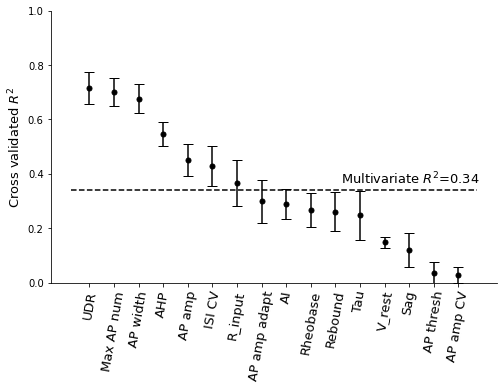

In [35]:
# For the revision, with human ion channel genes:
order=np.argsort(np.array([individual_R2_scores[key] for key in individual_R2_scores]))[::-1]
fig, ax = plt.subplots(1,1,figsize=(8,5))
# ax.scatter(
#            np.array([key for key in individual_R2_scores])[order],
#            np.array([individual_R2_scores[key] for key in individual_R2_scores])[order],
#            color='k'
#           )
ax.errorbar(np.array([key for key in individual_R2_scores])[order],
            np.array([individual_R2_scores[key] for key in individual_R2_scores])[order],
            np.array([individual_R2_scores_std[key] for key in individual_R2_scores_std])[order],
            marker='.', color='k', markersize=10, capsize=5, linestyle='none')
ax.hlines(R2_full,
          xmin=ax.get_xlim()[0],
          xmax=ax.get_xlim()[1],
          linestyle='dashed')
ax.set_ylim(ymin=0,ymax=1)
ax.annotate(r'Multivariate $R^2$={0:.2f}'.format(R2_full),
           (ax.get_xlim()[0]+1.3*(ax.get_xlim()[1]-ax.get_xlim()[0])/2, R2_full+0.02),
            fontsize=13)
plt.xticks(rotation='80', fontsize=13)
ax.set_ylabel(r'Cross validated $R^2$', fontsize=13)
sns.despine()
plt.savefig('./figures/preliminary/individual_ephys_prediction_scores_with_ion_channel_genes.png',
            bbox_inches = 'tight',
            pad_inches = 0)
plt.savefig('./figures/preliminary/individual_ephys_prediction_scores_with_ion_channel_genes.pdf',
            bbox_inches = 'tight',
            pad_inches = 0)

In [ ]:
# For the revision, with mouse ion channel genes:
order=np.argsort(np.array([individual_R2_scores[key] for key in individual_R2_scores]))[::-1]
fig, ax = plt.subplots(1,1,figsize=(8,5))
# ax.scatter(
#            np.array([key for key in individual_R2_scores])[order],
#            np.array([individual_R2_scores[key] for key in individual_R2_scores])[order],
#            color='k'
#           )
ax.errorbar(np.array([key for key in individual_R2_scores])[order],
            np.array([individual_R2_scores[key] for key in individual_R2_scores])[order],
            np.array([individual_R2_scores_std[key] for key in individual_R2_scores_std])[order],
            marker='.', color='k', markersize=10, capsize=5, linestyle='none')
ax.hlines(R2_full,
          xmin=ax.get_xlim()[0],
          xmax=ax.get_xlim()[1],
          linestyle='dashed')
ax.set_ylim(ymin=0,ymax=1)
ax.annotate(r'Multivariate $R^2$={0:.2f}'.format(R2_full),
           (ax.get_xlim()[0]+1.3*(ax.get_xlim()[1]-ax.get_xlim()[0])/2, R2_full+0.02),
            fontsize=13)
plt.xticks(rotation='80', fontsize=13)
ax.set_ylabel(r'Cross validated $R^2$', fontsize=13)
sns.despine()
plt.savefig('./figures/preliminary/individual_ephys_prediction_scores_with_ion_channel_genes.png',
            bbox_inches = 'tight',
            pad_inches = 0)
plt.savefig('./figures/preliminary/individual_ephys_prediction_scores_with_ion_channel_genes.pdf',
            bbox_inches = 'tight',
            pad_inches = 0)

In [ ]:
with open('KerasSavedModels/scala_2020_with_ion_channel_genes_tf2/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso.pickle', 'wb') as f:
    pickle.dump([r2_before_unfreezing, r2_before_unfreezing_tr, \
                 r2_after_unfreezing, r2_after_unfreezing_tr, \
                 r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
                 r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr], f)

In the next section we perform reduced-rank regression cross validation (rank = 2 and full rank).

In [ ]:
# CV sRRR rank = 2

lambdas = np.arange(.1,2,.1)
alphas = np.array([1])

rank = 2
folds = 10
seed = 42

r2_sRRR_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_rank2_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank2_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
nonzero_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
corrs_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))
corrs_relaxed_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))


t = time.time()

np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    x_train = x_train.astype('float64')
    y_train = y_train.astype('float64')
    x_test = x_test.astype('float64')
    y_test = y_test.astype('float64')
    
    for i,a in enumerate(lambdas):
        #print('Lambdau: ', a)
        for j, b in enumerate(alphas):
            #print('Alpha: ', b)
            vx,vy = sparseRRR.elastic_rrr(x_train, y_train, lambdau=a, alpha=b, rank=rank, sparsity='row-wise')

            nz = np.sum(np.abs(vx), axis=1) != 0
            if np.sum(nz) < rank:
                nonzero_rank2[cvfold, j, i] = np.nan
                continue

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank2[cvfold, j, i] = np.nan
                continue

            nonzero_rank2[cvfold, j, i] = np.sum(nz)
            r2_sRRR_rank2[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum(y_test**2)
            r2_sRRR_rank2_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum(y_train**2)
            for r in range(rank):
                corrs_rank2[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]

            # Relaxation
            vx[nz,:],vy = sparseRRR.elastic_rrr(x_train[:,nz], y_train, lambdau=a, alpha=0, rank=rank, sparsity='row-wise')

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank2[cvfold, j, i] = np.nan
                continue

            r2_sRRR_relaxed_rank2[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum(y_test**2)
            r2_sRRR_relaxed_rank2_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum(y_train**2)
            for r in range(rank):
                corrs_relaxed_rank2[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]
            #print(r2_sRRR_relaxed_rank2[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

In [ ]:
with open('KerasSavedModels/scala_2020_with_ion_channel_genes_tf2/sRRR_vs_Bottleneck_rank2_CV_lasso.pickle', 'wb') as f:
    pickle.dump([r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2], f)

In [ ]:
# CV sRRR full rank

lambdas = np.arange(.1,2,.1)
alphas = np.array([1])

rank = ephys.shape[1]
folds = 10
seed = 42

r2_sRRR_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_rank16_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank16_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
nonzero_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
corrs_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))
corrs_relaxed_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))


t = time.time()

np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    x_train = x_train.astype('float64')
    y_train = y_train.astype('float64')
    x_test = x_test.astype('float64')
    y_test = y_test.astype('float64')
    
    for i,a in enumerate(lambdas):
        #print('Labmdau: ', a)
        for j, b in enumerate(alphas):
            #print('Alpha: ', b)
            vx,vy = sparseRRR.elastic_rrr(x_train, y_train, lambdau=a, alpha=b, rank=rank, sparsity='row-wise')

            nz = np.sum(np.abs(vx), axis=1) != 0
            if np.sum(nz) < rank:
                nonzero_rank16[cvfold, j, i] = np.nan
                continue

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank16[cvfold, j, i] = np.nan
                continue

            nonzero_rank16[cvfold, j, i] = np.sum(nz)
            r2_sRRR_rank16[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum(y_test**2)
            r2_sRRR_rank16_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum(y_train**2)
            for r in range(rank):
                corrs_rank16[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]

            # Relaxation
            vx[nz,:],vy = sparseRRR.elastic_rrr(x_train[:,nz], y_train, lambdau=a, alpha=0, rank=rank, sparsity='row-wise')

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank16[cvfold, j, i] = np.nan
                continue

            r2_sRRR_relaxed_rank16[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum(y_test**2)
            r2_sRRR_relaxed_rank16_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum(y_train**2)
            for r in range(rank):
                corrs_relaxed_rank16[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]
            #print(r2_sRRR_relaxed_rank16[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

In [ ]:
with open('KerasSavedModels/scala_2020_with_ion_channel_genes_tf2/sRRR_vs_Bottleneck_rank16_CV_lasso.pickle', 'wb') as f:
    pickle.dump([r2_sRRR_rank16, r2_sRRR_relaxed_rank16, r2_sRRR_rank16_tr, r2_sRRR_relaxed_rank16_tr, \
                nonzero_rank16, corrs_rank16, corrs_relaxed_rank16], f)

Let us now analyse and visualise the differences.

In [26]:
lambdas = np.arange(.1,2,.1)
alphas = np.array([1])

In [27]:
with open('KerasSavedModels/scala_2020_with_ion_channel_genes_tf2/sRRR_vs_Bottleneck_rank2_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2 = pickle.load(f)

In [28]:
with open('KerasSavedModels/scala_2020_with_ion_channel_genes_tf2/sRRR_vs_Bottleneck_rank16_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank16, r2_sRRR_relaxed_rank16, r2_sRRR_rank16_tr, r2_sRRR_relaxed_rank16_tr, \
                nonzero_rank16, corrs_rank16, corrs_relaxed_rank16 = pickle.load(f)

In [29]:
with open('KerasSavedModels/scala_2020_with_ion_channel_genes_tf2/Bottleneck_pre_tr_lasso.pickle', 'rb') as f:
    CE_loss, CE_loss_tr, pre_tr_hist, pre_tr_hist_tr = pickle.load(f)

In [30]:
with open('KerasSavedModels/scala_2020_with_ion_channel_genes_tf2/Bottleneck_r2_straight_regr_lasso.pickle', 'rb') as f:
    r2_straight_regr, r2_straight_regr_tr, \
    r2_straight_regr_ap, r2_straight_regr_ap_tr, \
    r2_straight_regr_hist, r2_straight_regr_hist_tr = pickle.load(f)

In [31]:
with open('KerasSavedModels/scala_2020_with_ion_channel_genes_tf2/Bottleneck_r2_pre_tr_and_straight_regr_lasso.pickle', 'rb') as f:
    r2_pretr_straight_regr, r2_pretr_straight_regr_tr, \
    r2_pretr_straight_regr_ap, r2_pretr_straight_regr_ap_tr, \
    r2_pretr_straight_regr_hist, r2_pretr_straight_regr_hist_tr = pickle.load(f)

In [32]:
with open('KerasSavedModels/scala_2020_with_ion_channel_genes_tf2/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso.pickle', 'rb') as f:
    r2_before_unfreezing, r2_before_unfreezing_tr, \
    r2_after_unfreezing, r2_after_unfreezing_tr, \
    r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
    r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr = pickle.load(f)

In [33]:
# Select closest to 25 genes value
# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

before's and after's

In [34]:
print(r_rank16_r[np.isclose(n_rank16, 25, atol=5)][0], '+/-',
      np.nanstd(r2_sRRR_relaxed_rank16, axis=0)[0, :][np.isclose(n_rank16, 25, atol=5)][0])

0.35837160167006094 +/- 0.025765047569708776


In [35]:
print(r_rank2_r[np.isclose(n_rank2, 25, atol=5)][0], '+/-',
      np.nanstd(r2_sRRR_relaxed_rank2, axis=0)[0, :][np.isclose(n_rank2, 25, atol=5)][0])

0.3280056711845399 +/- 0.02555138380070412


In [36]:
print(np.mean(r2_freeze_unfreeze_hist,axis=0)[2,0,-1], '+/-', np.std(r2_freeze_unfreeze_hist,axis=0)[2,0,-1])

0.3490114152431488 +/- 0.026578726918978498


In [37]:
print(np.mean(r2_straight_regr_hist,axis=0)[0,0,-1], '+/-', np.std(r2_straight_regr_hist,axis=0)[0,0,-1])

0.33916009962558746 +/- 0.02517795704387026


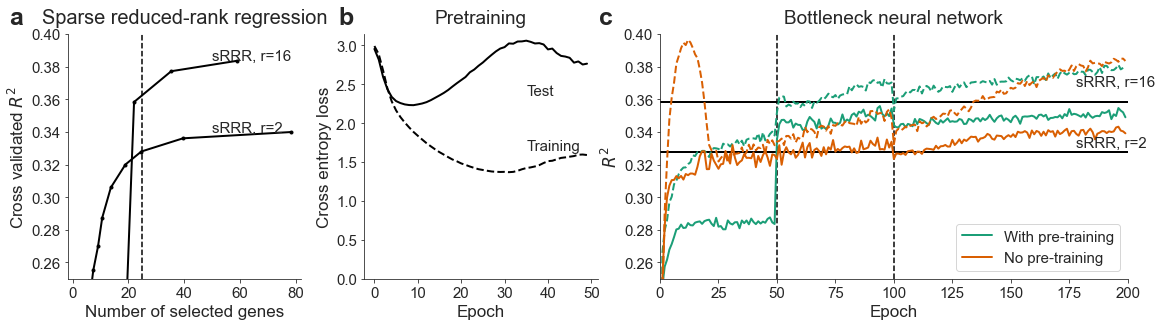

In [38]:
# For the revision, with ion channel genes:
linewidth = 2
sns_styleset()

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    cr_2 = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    cr_16= np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]
    
    

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

# All together in one plot for the paper
fig = plt.figure(figsize=(19, 4.5))
widths = [1, 1, 2]
heights = [1]
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths,
                          height_ratios=heights)
ax1 = fig.add_subplot(spec[0, 0])
ax1.plot(n_2, cr_2, '.-', c = np.array([0, 0, 0])/256, linewidth=2)
ax1.plot(n_16[1:], cr_16[1:], '.-', c = np.array([0, 0, 0]) / 256, linewidth=2)
ax1.set_ylim([0.25,0.4])
ax1.set_xlabel('Number of selected genes', fontsize = 17)
ax1.set_ylabel(r'Cross validated $R^2$', fontsize = 17)
ax1.set_title('Sparse reduced-rank regression', fontsize = 20, y=1.02)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax1.vlines(x=25, ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linestyles='dashed')
ax1.annotate('sRRR, r=16', (50, np.max(cr_16)+0.0003), fontsize=15)
ax1.annotate('sRRR, r=2', (50, np.max(cr_2)+0.0003), fontsize=15)


ax2 = fig.add_subplot(spec[0, 1])
ax2.plot(range(50), np.mean(pre_tr_hist_tr, axis=(0, 2))[2, :], \
         '--', c = 'k', linewidth=linewidth)
ax2.plot(range(50), np.mean(pre_tr_hist, axis=(0, 2))[2, :], \
         c = 'k', linewidth=linewidth)
ax2.set_title('Pretraining', fontsize = 19, y=1.02)
ax2.set_xlabel('Epoch', fontsize = 17)
ax2.set_ylabel('Cross entropy loss', fontsize = 17)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='minor', labelsize=15)
ax2.set_ylim([0, ax2.get_ylim()[1]])
ax2.annotate('Training', (35, 1.65), fontsize=15)
ax2.annotate('Test', (35, 2.36), fontsize=15)
ax2.set_xticks(np.arange(0, 60, 10))

epochs_used=200
ax3 = fig.add_subplot(spec[0, 2])
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr, axis=(0))[2,0,:], \
         '--', c = '#1b9e77', linewidth=linewidth)
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist, axis=(0))[2,0,:], \
         c = '#1b9e77', linewidth=linewidth, label='With pre-training')
# ax3.plot(range(epochs_used), np.mean(r2_pretr_straight_regr_hist_tr, axis=(0))[0,0,:], \
#          '--', c = '#d95f02', linewidth=linewidth)
# ax3.plot(range(epochs_used), np.mean(r2_pretr_straight_regr_hist, axis=(0))[0,0,:], \
#          c = '#d95f02', linewidth=linewidth, label='Pre-training + no freezing')
ax3.plot(range(epochs_used), np.mean(r2_straight_regr_hist_tr, axis=(0))[0,0,:], \
         '--', c = '#d95f02', linewidth=linewidth)
ax3.plot(range(epochs_used), np.mean(r2_straight_regr_hist, axis=(0))[0,0,:], \
         c = '#d95f02', linewidth=linewidth, label='No pre-training')
ax3.hlines(r_rank16_r[np.isclose(n_rank16, 25, atol=5)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax3.hlines(r_rank2_r[np.isclose(n_rank2, 25, atol=5)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax3.set_ylim([0.25,0.4])
ax3.set_xlim([0,200])
ax3.set_xticks(np.arange(0, 225, 25))
ax3.annotate('sRRR, r=16', (178, r_rank16_r[np.isclose(n_rank16, 25, atol=5)]+0.01), fontsize=15)
ax3.annotate('sRRR, r=2', (178, r_rank2_r[np.isclose(n_rank2, 25, atol=5)]+0.003), fontsize=15)
ax3.set_title('Bottleneck neural network', fontsize = 19, y=1.02)
ax3.set_xlabel('Epoch', fontsize = 17)
ax3.set_ylabel(r'$R^2$', fontsize = 17)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.tick_params(axis='both', which='minor', labelsize=15)
ax3.legend(loc='lower right', fontsize=15)
ax3.vlines(x=50, ymin=ax3.get_ylim()[0], ymax=ax3.get_ylim()[1], linestyles='dashed')
ax3.vlines(x=100, ymin=ax3.get_ylim()[0], ymax=ax3.get_ylim()[1], linestyles='dashed')

plt.text(-0.25, 1.04, 'a', transform = ax1.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.11, 1.04, 'b', transform = ax2.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.13, 1.04, 'c', transform = ax3.transAxes, fontsize=25, fontweight='bold')
sns.despine()

# plt.savefig('figures/Lasso_training_curves_with_mouse_ion_channel_genes.pdf', bbox_inches='tight',
#     pad_inches=0)
# plt.savefig('figures/Lasso_training_curves_with_mouse_ion_channel_genes.png', bbox_inches='tight',
#     pad_inches=0)

# Extensions

How many nodes in the bottleneck do we need to really perform clearly above (and relatively soon above) the full rank linear model?

In [81]:
importlib.reload(bottleneck_networks)

<module 'bottleneck_networks' from '/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/sBNN/bottleneck_networks.py'>

In [82]:
from bottleneck_networks import ClassificationPreTrain

In [83]:
# What about using different amount of nodes in the bottleneck?
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs


t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]
clusters_ = clusters[ind]
ind_pre_train = ind_pre_training_clusters[ind]

CE_loss = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0]))
CE_loss_tr = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0]))
pre_tr_hist = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0], epochs))
pre_tr_hist_tr = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0], epochs))


for u,f in enumerate(range(2,12,2)):
    nodes_list=[512, 128, f, 128, 512]
    print('Bottleneck with {} nodes'.format(f))
    # CV folds
    for cvfold in range(folds):
        print('\nCVFOLD: ', cvfold)
        indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
        indtrain = np.setdiff1d(np.arange(n), indtest)
        x_train = np.copy(X[indtrain,:])
        clusters_train = np.copy(clusters_[indtrain])
        y_train = np.copy(Y[indtrain,:])
        x_test = np.copy(X[indtest,:])
        clusters_test = np.copy(clusters_[indtest])
        y_test = np.copy(Y[indtest,:])

        # Mean centering (like sRRR)
        X_mean = np.mean(x_train, axis=0)
        x_train -= X_mean
        x_test -= X_mean
        Y_mean = np.mean(y_train, axis=0)
        y_train -= Y_mean
        y_test -= Y_mean

        # In our training set we now look for a 'pretraining' training and test data set that we can use
        # for pretraing a classification network, i.e. picking the best model will be dones with a seperate val set in our
        # training set for regression.

        x_train_pre_tr = x_train[ind_pre_train[indtrain], :]
        clusters_train_pre_tr = clusters_train[ind_pre_train[indtrain]]

        pre_train_size = 0.6
        train_cnt = round(x_train_pre_tr.shape[0]*pre_train_size)
        x_train_pre_tr_ = x_train_pre_tr[:train_cnt, :]
        x_test_pre_tr_ = x_train_pre_tr[train_cnt:, :]
        clusters_train_pre_tr_ = clusters_train_pre_tr[:train_cnt]
        clusters_test_pre_tr_ = clusters_train_pre_tr[train_cnt:]

        for i, l2 in enumerate(l2_params):
            #print('Ridge penalty: ', l2)
            for j, l1 in enumerate(l1_params):
                #print('Lasso penalty: ', l1)


                input_dim = x_train.shape[1]
                output_dim = to_categorical(clusters_train_pre_tr).shape[1]
                BN_Classification = ClassificationPreTrain(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, \
                                                           output_dim=output_dim, nodes_list=nodes_list)
                CE_train, CE_test, train_hist, test_hist = BN_Classification.train(x_train=x_train_pre_tr_, \
                                                                                   cluster_train=clusters_train_pre_tr_, \
                                                                                   x_test=x_test_pre_tr_, \
                                                                                   cluster_test=clusters_test_pre_tr_, \
                                                                                   epochs=epochs, bs=bs, patience=patience, \
                                                                                   cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                                   verbose=0, \
                                                                                   output_name='nodes_list_{}'.format(u))
                CE_loss[u, cvfold, j, i] = CE_test
                CE_loss_tr[u, cvfold, j, i] = CE_train
                pre_tr_hist[u, cvfold, j, i] = test_hist
                pre_tr_hist_tr[u, cvfold, j, i] = train_hist
                #print('Test CE loss (pre-trainin): ', CE_loss[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

Bottleneck with 2 nodes

CVFOLD:  0
[INFO] training network...
437/437 [==============================] - 0s 84us/sample - loss: 55.8082 - categorical_crossentropy: 2.1601

CVFOLD:  1
[INFO] training network...
437/437 [==============================] - 0s 83us/sample - loss: 48.6748 - categorical_crossentropy: 2.0537

CVFOLD:  2
[INFO] training network...
437/437 [==============================] - 0s 82us/sample - loss: 48.9267 - categorical_crossentropy: 1.9789

CVFOLD:  3
[INFO] training network...
437/437 [==============================] - 0s 91us/sample - loss: 55.2931 - categorical_crossentropy: 2.1016

CVFOLD:  4
[INFO] training network...
437/437 [==============================] - 0s 87us/sample - loss: 48.2927 - categorical_crossentropy: 2.0351

CVFOLD:  5
[INFO] training network...
437/437 [==============================] - 0s 91us/sample - loss: 55.3030 - categorical_crossentropy: 2.1135

CVFOLD:  6
[INFO] training network...
437/437 [==============================] - 0s 94u

In [84]:
from bottleneck_networks import FreezeUnfreeze

In [86]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
unfreeze = [False, False, True, True, True, True] # last 4 layers can be trained only first
prune=True

r2_before_unfreezing = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0]))
r2_before_unfreezing_tr = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_tr = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_ap = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_ap_tr = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0]))
r2_freeze_unfreeze_hist = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_freeze_unfreeze_hist_tr = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

for u,f in enumerate(range(2,12,2)):
    nodes_list=[512, 128, f, 128, 512]
    print('Bottleneck with {} nodes'.format(f))
    # CV folds
    for cvfold in range(folds):
        print('\nCVFOLD: ', cvfold)
        indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
        indtrain = np.setdiff1d(np.arange(n), indtest)
        x_train = np.copy(X[indtrain,:])
        y_train = np.copy(Y[indtrain,:])
        x_test = np.copy(X[indtest,:])
        y_test = np.copy(Y[indtest,:])

        # Mean centering (like sRRR)
        X_mean = np.mean(x_train, axis=0)
        x_train -= X_mean
        x_test -= X_mean
        Y_mean = np.mean(y_train, axis=0)
        y_train -= Y_mean
        y_test -= Y_mean

        input_dim = x_train.shape[1]
        output_dim = y_train.shape[1]

        for i, l2 in enumerate(l2_params):
            #print('Ridge penalty: ', l2)
            for j, l1 in enumerate(l1_params):
                #print('Lasso penalty: ', l1)

                pre_trained_weights_h5 = 'KerasSavedModels/{}/Classification_last_weights_{}_{}_{}.h5'.\
                                                format('nodes_list_{}'.format(u),cvfold, j, i)
                input_dim = x_train.shape[1]
                output_dim = y_train.shape[1]
                BN_PreTrFreezeUnfreeze = FreezeUnfreeze(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, output_dim=output_dim, \
                                                           unfreeze = unfreeze, \
                                                           pre_trained_weights=pre_trained_weights, \
                                                           pre_trained_weights_h5=pre_trained_weights_h5, \
                                                           nodes_list=nodes_list)
                r2_before_unfreezing_train, r2_before_unfreezing_test, \
                    r2_after_unfreezing_train, r2_after_unfreezing_test, \
                    r2_after_unfreezing_train_ap, r2_after_unfreezing_test_ap, \
                    train_hist, test_hist = BN_PreTrFreezeUnfreeze.train(x_train=x_train, y_train=y_train, \
                                                                        x_test=x_test, y_test=y_test, \
                                                                        epochs=epochs, bs=bs, patience=patience, \
                                                                        cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                        prune=prune, geneNames=gene_names, \
                                                                        verbose=0)
                r2_before_unfreezing[u, cvfold, j, i] = r2_before_unfreezing_test
                r2_before_unfreezing_tr[u, cvfold, j, i] = r2_before_unfreezing_train
                r2_after_unfreezing[u, cvfold, j, i] = r2_after_unfreezing_test
                r2_after_unfreezing_tr[u, cvfold, j, i] = r2_after_unfreezing_train
                r2_after_unfreezing_ap[u, cvfold, j, i] = r2_after_unfreezing_test_ap
                r2_after_unfreezing_ap_tr[u, cvfold, j, i] = r2_after_unfreezing_train_ap
                r2_freeze_unfreeze_hist[u, cvfold, j, i] = test_hist
                r2_freeze_unfreeze_hist_tr[u, cvfold, j, i] = train_hist
                #print('Test R^2 score (before unfreezing): ', r2_before_unfreezing[cvfold, j, i])
                #print('Test R^2 score (after unfreezing): ', r2_after_unfreezing[cvfold, j, i])
                #print('Test R^2 score (after unfreezing and after pruning): ', r2_after_unfreezing_ap[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

Bottleneck with 2 nodes

CVFOLD:  0
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Erbb4' 'Mical2' 'Nell2' 'Phactr1' 'Kcnc2' 'Gabra1' 'Atp1a3' 'Gm11549'
 'Plch2' 'Cplx1' 'Unc13c' 'Gabrd' 'Kcnip2' 'Enpp2' 'Grm7' 'Gm49948'
 'Elfn1' 'Htr3a' 'Galnt14' 'Ndn' 'Lamp5' 'Gad1' 'Tac2' 'Pvalb' 'Sst']
[INFO] training network...
Train R^2 before unfreezing:  0.33830320835113525
Test R^2 before unfreezing:  0.33475446701049805
Train R^2 after unfreezing:  0.4302493929862976
Test R^2 after unfreezing:  0.4383460283279419
Train R^2 after unfreezing and pruning:  0.4181750416755676
Test R^2 after unfreezing and pruning:  0.4496825337409973

CVFOLD:  1
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Slc5a7' 'Nrip3' 'Elfn1' 'Gpm6b' 'Elmo1' 'Cdc42se2' 'Cplx1' 'Pfkp'
 'Grip1' 'Sparcl1' 'Galnt14' 'Col24a1' 'Pcp4l1' 'Enpp2' 'Tac2' 'Plch2'
 'Erbb4' 'Atp1a3' 'Ndn' 'Gm49948' 'Lamp5' 'Gad1' 'Sst' 'Pvalb' 'Vip']
[INFO] training network...
Tr

[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Syt1' 'Plch2' 'Phactr1' 'Sparcl1' 'Cacna1e' 'Gabra1' 'Pdyn' 'Coro6'
 'Elmo1' 'Tafa1' 'Galnt14' 'Ndst3' 'Satb1' 'Tac2' 'Thsd7a' 'Cplx1' 'Fxyd6'
 'Erbb4' 'Ndn' 'Lamp5' 'Htr3a' 'Sst' 'Pvalb' 'Gad1' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.4395413398742676
Test R^2 before unfreezing:  0.3468536138534546
Train R^2 after unfreezing:  0.4916002154350281
Test R^2 after unfreezing:  0.44237321615219116
Train R^2 after unfreezing and pruning:  0.4629012942314148
Test R^2 after unfreezing and pruning:  0.436553955078125

CVFOLD:  4
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Gabra1' 'Afap1' 'Fxyd6' 'Tac2' 'Pamr1' 'Plch2' 'Cplx3' 'Coro6' 'Enpp2'
 'Phactr1' 'Tafa1' 'Gm49948' 'Cbln2' 'Lamp5' 'Atp1a3' 'Ndst3' 'Cplx1'
 'Ndn' 'Galnt14' 'Gad1' 'Htr3a' 'Erbb4' 'Sst' 'Vip' 'Pvalb']
[INFO] training network...
Train R^2 before unfreezing:  0.4619518518447876
Te

[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Atp1a3' 'Afap1' 'Gabrd' 'Pcdh7' 'Cdh13' 'Galnt14' 'Pik3r5' 'Tac2'
 'Gm49948' 'Cplx1' 'Cplx3' 'Elmo1' 'Fxyd6' 'Calb1' 'Cbln2' 'Enpp2' 'Htr3a'
 'Ndn' 'Erbb4' 'Ndst3' 'Gad1' 'Lamp5' 'Sst' 'Pvalb' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.45131832361221313
Test R^2 before unfreezing:  0.36073189973831177
Train R^2 after unfreezing:  0.5129768252372742
Test R^2 after unfreezing:  0.44795727729797363
Train R^2 after unfreezing and pruning:  0.47178345918655396
Test R^2 after unfreezing and pruning:  0.4241349697113037

CVFOLD:  7
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Calb1' 'Mical2' 'Chrnb3' 'Afap1' 'Npy1r' 'Lingo2' 'Sparcl1' 'Atp1a3'
 'Gm49948' 'Phactr1' 'Enpp2' 'Elmo1' 'Ndst3' 'Fxyd6' 'Htr3a' 'Cplx1'
 'Tac2' 'Lamp5' 'Galnt14' 'Erbb4' 'Ndn' 'Gad1' 'Sst' 'Pvalb' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.4524297118186

[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Atp1a3' 'Scg2' 'Npy' 'Gabra1' 'Fxyd6' 'Reln' 'Pde1a' 'Satb1' 'Thsd7a'
 'Elmo1' 'Galnt14' 'Cplx1' 'Coro6' 'Pamr1' 'Tac2' 'Plch2' 'Erbb4' 'Ndn'
 'Htr3a' 'Pdyn' 'Lamp5' 'Gad1' 'Pvalb' 'Sst' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.467689573764801
Test R^2 before unfreezing:  0.39991146326065063
Train R^2 after unfreezing:  0.5149269998073578
Test R^2 after unfreezing:  0.44602882862091064
Train R^2 after unfreezing and pruning:  0.4800705909729004
Test R^2 after unfreezing and pruning:  0.4118685722351074
Bottleneck with 10 nodes

CVFOLD:  0
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Pcdh7' 'Gm43670' 'Gm11549' 'Gabra1' 'Cbln2' 'Gm49948' 'Pamr1' 'Elmo1'
 'Ndst3' 'Atp1a3' 'Fxyd6' 'Pdyn' 'Htr3a' 'Enpp2' 'Ndn' 'Thsd7a' 'Erbb4'
 'Galnt14' 'Lamp5' 'Cplx1' 'Tac2' 'Sst' 'Gad1' 'Pvalb' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0

In [87]:
with open('KerasSavedModels/scala_2020/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso_multiple_nodes.pickle', 'wb') as f:
    pickle.dump([r2_before_unfreezing, r2_before_unfreezing_tr, \
                 r2_after_unfreezing, r2_after_unfreezing_tr, \
                 r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
                 r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr], f)

In [88]:
with open('KerasSavedModels/scala_2020/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso_multiple_nodes.pickle', 'rb') as f:
    r2_before_unfreezing, r2_before_unfreezing_tr, \
    r2_after_unfreezing, r2_after_unfreezing_tr, \
    r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
    r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr = pickle.load(f)

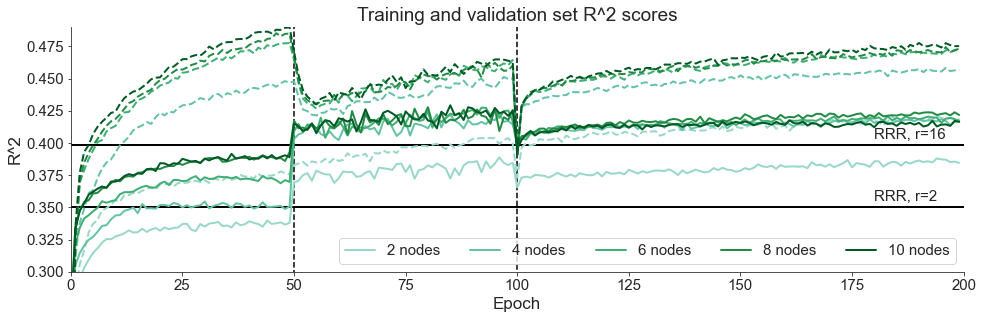

In [89]:
# The learning curves for our favourite model: pre-tr + train last 4 layers only + train all + prune
linewidth = 2

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

epochs_used = 200
fig = plt.figure(figsize = (16, 4.5))
ax = fig.add_subplot(111)
colours = ['#99d8c9', '#66c2a4', '#41ae76', '#238b45', '#005824']
for u,f in enumerate(range(2,12,2)):
    ax.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr, axis = (1, 2))[u, 0, :], \
             '--', c = colours[u], linewidth=linewidth, label=None)
    ax.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist, axis = (1, 2))[u, 0, :], \
             c = colours[u], linewidth=linewidth, label='{} nodes'.format(f))
ax.hlines(r_rank16_r[np.isclose(n_rank16, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax.hlines(r_rank2_r[np.isclose(n_rank2, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax.annotate('RRR, r=16', (180, r_rank16_r[np.isclose(n_rank16, 25, atol=3)]+0.005), fontsize=15)
ax.annotate('RRR, r=2', (180, r_rank2_r[np.isclose(n_rank2, 25, atol=3)]+0.005), fontsize=15)
ax.vlines(x=50, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyles='dashed')
ax.vlines(x=100, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyles='dashed')
ax.set_ylim([0.3, 0.49])
ax.set_xlim([0, 200])
ax.set_title('Training and validation set R^2 scores', fontsize = 19)
ax.set_xlabel('Epoch', fontsize = 17)
ax.set_ylabel('R^2', fontsize = 17)
ax.legend(loc='lower right', ncol=5, fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
sns.despine()

plt.savefig('figures/Lasso_training_curves_different_nodes.pdf', bbox_inches='tight',
    pad_inches=0)
plt.savefig('figures/Lasso_training_curves_different_nodes.png', bbox_inches='tight',
    pad_inches=0)